In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
class args:
    # ["GRB180423A", "GRB170527A", "GRB150716A"]
    def __init__(self, 
                 grb_name="GRB180423A", 
                 tw_in_second=10, 
                 ncpu=4, 
                 n_injs=np.round(np.r_[0:9.1:0.2], 2)):
        self.grb_name = grb_name
        self.tw_in_second = tw_in_second
        self.ncpu = ncpu
        self.n_injs = n_injs

In [3]:
from scipy.optimize import curve_fit
def objective(x, N):
    return 1 - (1 - x)**N

In [4]:
ag = args(grb_name="GRB180423A")
bg_files = sorted(glob(ANA_DIR + f"/allsky_scan/with_prior_background/tw*/{ag.grb_name}_*.npz"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{ag.grb_name}")]))

In [5]:
bgs = np.array([sparse.load_npz(bg_file).toarray()[0] for bg_file in bg_files])
bgs_sorted = np.apply_along_axis(sorted, 1, bgs)

In [6]:
pvals = []
for bg, bg_sorted in zip(bgs, bgs_sorted):
    pvals.append(np.apply_along_axis(lambda x: (bg.size - np.searchsorted(bg_sorted, x, side='left')) / bg.size, 0, bg))
pvals = np.array(pvals)
best_pvals = np.sort(pvals.min(axis=0))


In [7]:
best_pvals

array([1.e-06, 1.e-06, 1.e-06, ..., 1.e+00, 1.e+00, 1.e+00])

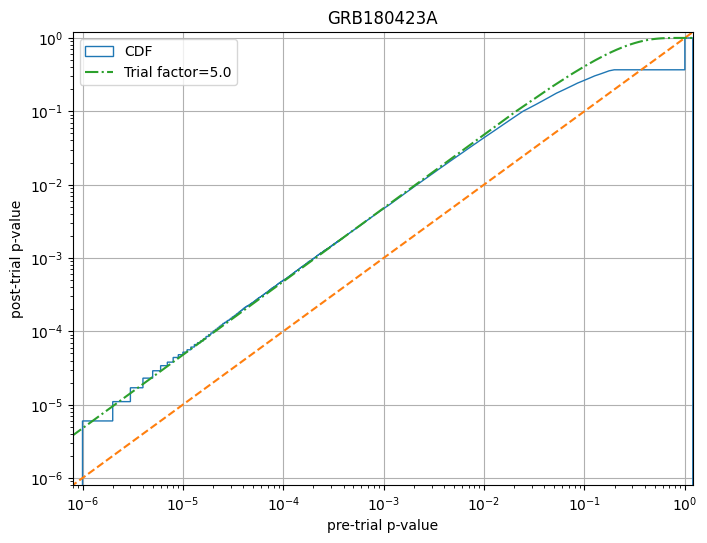

In [8]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(best_pvals, 
        bins=np.r_[np.unique(best_pvals),1.2], 
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")
ax.plot(x, objective(x, 5.0), "-.", label="Trial factor=5.0")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.8e-6, 1.2)
ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("pre-trial p-value")
ax.set_ylabel("post-trial p-value")
ax.set_title(f"{ag.grb_name}")
ax.grid()
ax.legend()

## Save trial correction mapping in disk

In [59]:
hist, bin_edges = np.histogram(best_pvals, 
                               bins=np.r_[np.unique(best_pvals),1.2], 
                               density=True)
pre_trial_p = bin_edges
post_trial_p = np.r_[np.cumsum(hist*np.diff(bin_edges)), 1]
dt = np.dtype([('pre_trial_p', np.float32), ('post_trial_p', np.float32)])

In [61]:
pre_post = np.transpose(np.array([pre_trial_p, post_trial_p]))
pre_post = np.array(list(map(tuple, pre_post)), dtype=dt)

In [94]:
np.save(ANA_DIR + f"/effective_trial/{ag.grb_name}_effective_trial.npy", pre_post)

# Batch saving

In [113]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")


In [114]:
def save_effective_trial(grb_name):
    ag = args(grb_name=grb_name)
    bg_files = sorted(glob(ANA_DIR + f"/allsky_scan/with_prior_background/tw*/{ag.grb_name}_*.npz"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{ag.grb_name}")]))
    assert len(bg_files) > 0, print(f"cannot find bkg files of {ag.grb_name}")
        
    bgs = np.array([sparse.load_npz(bg_file).toarray()[0] for bg_file in bg_files])
    bgs_sorted = np.apply_along_axis(sorted, 1, bgs)
    
    pvals = []
    for bg, bg_sorted in zip(bgs, bgs_sorted):
        pvals.append(np.apply_along_axis(lambda x: (bg.size - np.searchsorted(bg_sorted, x, side='left')) / bg.size, 0, bg))
    pvals = np.array(pvals)
    best_pvals = np.sort(pvals.min(axis=0))
    
    hist, bin_edges = np.histogram(best_pvals, 
                               bins=np.r_[np.unique(best_pvals),1.2], 
                               density=True)
    pre_trial_p = bin_edges
    post_trial_p = np.r_[np.cumsum(hist*np.diff(bin_edges)), 1]
    dt = np.dtype([('pre_trial_p', np.float32), ('post_trial_p', np.float32)])
    
    pre_post = np.transpose(np.array([pre_trial_p, post_trial_p]))
    pre_post = np.array(list(map(tuple, pre_post)), dtype=dt)
    
    np.save(ANA_DIR + f"/effective_trial/{ag.grb_name}_effective_trial.npy", pre_post)
    

In [110]:
save_effective_trial(grb_name)

In [123]:
for i in range(2268, 2269):
    try:
        grb_name = df.grb_name.iloc[i]
        save_effective_trial(grb_name)
    except:
        raise Exception("Something wrong with grb idx {}: {}\n".format(i, grb_name))

Exception: Something wrong with grb idx 2268: GRB120426B


In [116]:
[i for i in range(1,5)]

[1, 2, 3, 4]

# Other plots

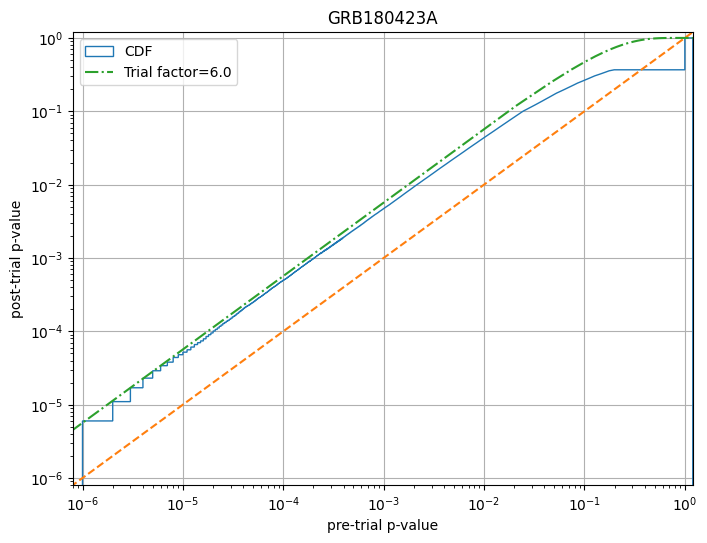

In [14]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(best_pvals, 
        bins=np.r_[np.unique(best_pvals),1.2], 
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")
ax.plot(x, objective(x, 6.0), "-.", label="Trial factor=6.0")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.8e-6, 1.2)
ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("pre-trial p-value")
ax.set_ylabel("post-trial p-value")
ax.set_title(f"{ag.grb_name}")
ax.grid()
ax.legend()

/usr/local/pace-apps/manual/packages/anaconda3/2020.02/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


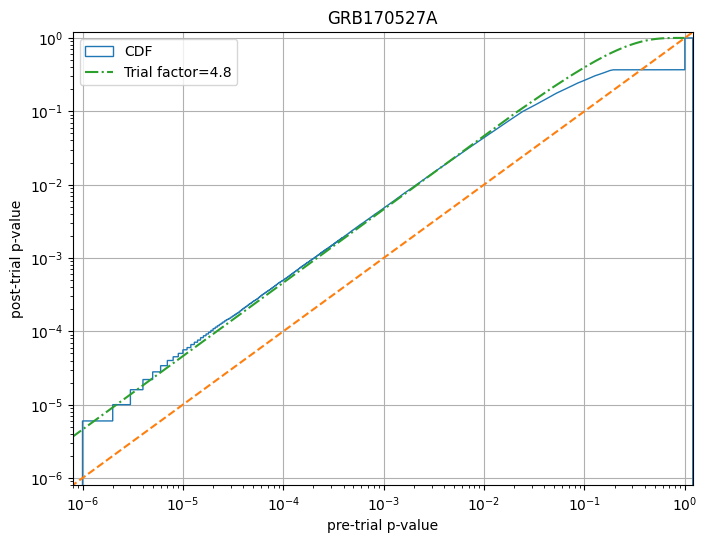

In [15]:
ag = args(grb_name="GRB170527A")
bg_files = sorted(glob(ANA_DIR + f"/allsky_scan/with_prior_background/tw*/{ag.grb_name}_*.npz"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{ag.grb_name}")]))

bgs = np.array([sparse.load_npz(bg_file).toarray()[0] for bg_file in bg_files])
bgs_sorted = np.apply_along_axis(sorted, 1, bgs)

pvals = []
for bg, bg_sorted in zip(bgs, bgs_sorted):
    pvals.append(np.apply_along_axis(lambda x: (bg.size - np.searchsorted(bg_sorted, x, side='left')) / bg.size, 0, bg))
pvals = np.array(pvals)
best_pvals = np.sort(pvals.min(axis=0))

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.hist(best_pvals, 
        bins=np.r_[np.unique(best_pvals),1.2], 
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")
ax.plot(x, objective(x, 4.8), "-.", label="Trial factor=4.8")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.8e-6, 1.2)
ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("pre-trial p-value")
ax.set_ylabel("post-trial p-value")
ax.set_title(f"{ag.grb_name}")
ax.grid()
ax.legend()

/usr/local/pace-apps/manual/packages/anaconda3/2020.02/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


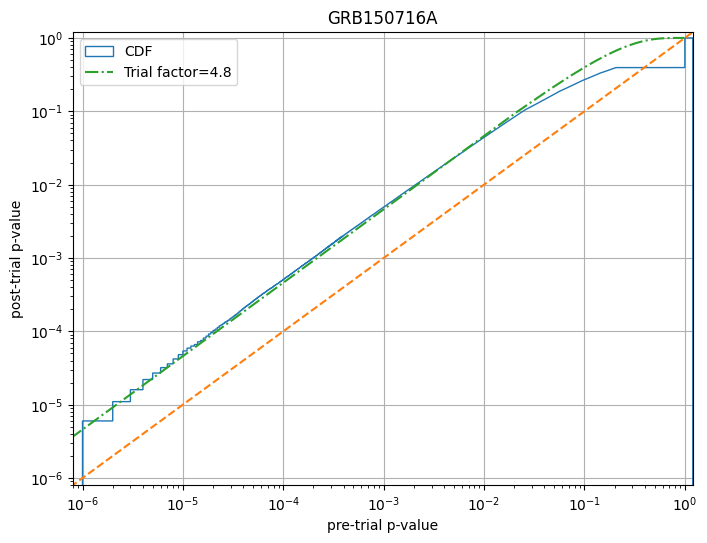

In [17]:
ag = args(grb_name="GRB150716A")
bg_files = sorted(glob(ANA_DIR + f"/allsky_scan/with_prior_background/tw*/{ag.grb_name}_*.npz"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{ag.grb_name}")]))

bgs = np.array([sparse.load_npz(bg_file).toarray()[0] for bg_file in bg_files])
bgs_sorted = np.apply_along_axis(sorted, 1, bgs)

pvals = []
for bg, bg_sorted in zip(bgs, bgs_sorted):
    pvals.append(np.apply_along_axis(lambda x: (bg.size - np.searchsorted(bg_sorted, x, side='left')) / bg.size, 0, bg))
pvals = np.array(pvals)
best_pvals = np.sort(pvals.min(axis=0))

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.hist(best_pvals, 
        bins=np.r_[np.unique(best_pvals),1.2], 
        density=True, 
        cumulative=True, 
        label='CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")
ax.plot(x, objective(x, 4.8), "-.", label="Trial factor=4.8")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.8e-6, 1.2)
ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("pre-trial p-value")
ax.set_ylabel("post-trial p-value")
ax.set_title(f"{ag.grb_name}")
ax.grid()
ax.legend()